In [1]:
import random

import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import trange

import torch
from torch import nn

source = "../source"
sys.path.append(source)


from data import seq_data
from preprocessing import OneHot
from compilation import Compiler, ScalarTracker, ActivationTracker
from data_analysis.automata import to_automaton_history, reduce_automaton, to_automaton
from visualization.animation import SliderAnimation
from visualization.activations import ActivationsAnimation
from visualization.automata import AutomatonAnimation, display_automata
from visualization.epochs import EpochAnimation

from model import Model
import publication

is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

random.seed(0)
torch.manual_seed(0)

GPU is available


In [9]:
a = np.array([[1, 2], [2, 3], [4, 5]])
a = np.mean(np.linalg.norm(a, axis=1))
a

np.float64(4.081581163465542)

In [2]:
save = False

In [3]:
## Load settings
settings = "rich"

(nonlinearity, gain, lr, P, L, n_epochs, max_seq_len) = (
    pd.read_csv("model settings/rnn.txt", sep=" ", header=0).loc[settings].to_numpy()
)
P, L, n_epochs, max_seq_len = int(P), int(L), int(n_epochs), int(max_seq_len)

In [4]:
max_seq_len = 8

In [5]:
## Generate data

# Define problem and data encoding
symbols = [0, 1]
encoding = OneHot(symbols)
problem = lambda seq: np.sum(seq) % 2  # XOR problem
# problem = lambda seq: (np.sum(seq) % 3) % 2

# Define sequence lengths for training and validation datasets
train_seq_lengths = list(range(1, max_seq_len + 1))
analysis_seq_lengths = train_seq_lengths
# analysis_seq_lengths = list(range(1, 8 + 1))
val_seq_length = 50
val_datapoints = 100

# Generate datasets
training_datasets = [
    seq_data(device, problem, encoding, seq_len=length) for length in train_seq_lengths
]
validation_datasets = [
    seq_data(
        device, problem, encoding, n_datapoints=val_datapoints, seq_len=val_seq_length
    )
]
analysis_data = [
    seq_data(device, problem, encoding, seq_len=length)
    for length in analysis_seq_lengths
]
tracked_datasets = validation_datasets + analysis_data + training_datasets

In [6]:
import torch
from torch import nn
from torch.optim import Optimizer

import numpy as np

from preprocessing import Encoding


class Transformer(nn.Module):
    """


    Attributes
    ----------
    encoding : Encoding
        An encoding from input symbols to neural activities
    input_size : int
        The size of one input symbol
    output_size : int
        The size of the output
    hidden_dim : int
        The number of hidden neurons
    n_layers : int
        The number of RNN layers
    device : device
        The device to put the model on
    nonlinearity : str
        Nonlinearity used in recurrent layer
    gain : float, default 0.1
        The gain of the initial rnn weights
    """

    def __init__(
        self,
        encoding: Encoding,
        input_size: int,
        output_size: int,
        hidden_dim: int,
        n_layers: int,
        device: torch.device,
        nonlinearity: str = "tanh",
        gain: float = 0.1,
    ):
        super(Transformer, self).__init__()

        self.device = device
        self.encoding = encoding
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # Defining the layers
        # self.rnn = nn.RNN(
        #     input_size,
        #     hidden_dim,
        #     n_layers,
        #     batch_first=True,
        #     nonlinearity=nonlinearity,
        # )
        self.fc_in = nn.Linear(input_size, hidden_dim, bias=True)
        self.ReLU = nn.LeakyReLU()
        self.transformer = nn.Transformer(
            d_model=hidden_dim, nhead=50, num_encoder_layers=4, bias=True
        )
        self.fc_out = nn.Linear(hidden_dim, output_size, bias=True)

        self.encoder = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=50)

        # for par in self.parameters():
        #     if len(par.shape) == 2:
        #         nn.init.xavier_normal_(par, gain=gain)
        #     if len(par.shape) == 1:
        #         nn.init.zeros_(par)
        # for name, param in self.named_parameters():
        #     if "weight" in name and param.data.dim() == 2:
        #         nn.init.kaiming_uniform_(param)
        # if param.data.dim() == 2:
        #     nn.init.xavier_normal_(param, gain=1)

        self.to(device)

    def forward(self, x, y):
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        # hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the self and obtaining outputs
        # y = torch.stack([y * 0] * (x.shape[1] - 1) + [y], axis=1)  # pad y with zeros
        # out = self.transformer(x, y)

        out = self.ReLU(self.fc_in(x))
        # out = self.transformer.encoder(out)
        out = self.encoder(out)
        out = out.max(dim=1)[0]
        # out = out[:, -1, :]
        out = self.ReLU(self.fc_out(out))

        hidden = out

        return out, hidden

    def predict(self, x):
        out = self(x, x)[0]
        # out = out[:, -1, :]
        prediction = torch.argmax(out).item()
        return prediction

    def train_step(self, optimizer: Optimizer, criterion, dataloader):
        self.train()
        av_loss = 0
        for batch in dataloader:
            inputs, outputs = batch
            optimizer.zero_grad()

            output, _ = self(inputs, outputs)

            # output = output[:, -1, :]

            # print(output)
            # print(outputs)

            loss = criterion(torch.squeeze(output), torch.squeeze(outputs))

            loss.backward()
            optimizer.step()
            av_loss += loss / len(dataloader)
        return av_loss


P = 1000

model = Transformer(
    encoding=encoding,
    input_size=2,
    output_size=2,
    hidden_dim=P,
    n_layers=L,
    device=device,
    nonlinearity=nonlinearity,
    gain=gain,
)

/home/loek/miniconda3/envs/rnn_structure/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [7]:
## Setup compiler
lr = 0.001
n_epochs = 2000
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=True, weight_decay=0.00)
compiler = Compiler(model, criterion, optimizer)
# initial_hidden = model.init_hidden(batch_size=1)[-1]
# hidden_function = lambda inputs: model(inputs)[1][-1]
output_function = lambda inputs: model(inputs)[0]
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    # "hidden": ActivationTracker(
    #     encoding,
    #     hidden_function,
    #     analysis_data,
    #     initial=lambda: initial_hidden,
    # ),
    # "output": ActivationTracker(encoding, output_function, analysis_data),
}

In [8]:
for _ in range(n_epochs):
    av_loss = 0
    for dataset in training_datasets[::-1]:
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=128)
        loss = model.train_step(optimizer, criterion, dataloader).item()
        av_loss += loss / len(dataloader)
    print(av_loss)

35.25481206178665
4.282965421676636
4.2422007620334625
4.117201209068298
3.37539079785347
3.6433010399341583
4.00490614771843
4.015331953763962
3.9927879571914673
3.9492194056510925
3.908480077981949
3.8771691024303436
3.850974678993225
3.818611055612564
3.432559549808502
3.915164202451706
4.015902400016785
4.028731733560562
4.015877604484558
3.9855583906173706
3.9576510190963745
3.929815858602524
3.8960157334804535
3.869011163711548
3.842617690563202
3.60829296708107
2.925633519887924
2.9971530735492706
2.76036736369133
2.9205084145069122
3.5057222843170166
3.897083818912506
3.9387514889240265
3.929310977458954
3.8985400199890137
3.560104876756668
3.2168162167072296
3.8298839330673218
3.836890161037445
3.8293874859809875
3.8291940093040466
3.807600259780884
3.7944977581501007
3.727127730846405
3.5320861786603928
3.3247769474983215
3.8479703068733215
3.8814777731895447
3.880414217710495
3.8731228709220886
3.8608287572860718
3.8493199944496155
3.8367453813552856
3.832404315471649
3.8148

KeyboardInterrupt: 

100%|██████████| 100/100 [00:02<00:00, 44.46it/s]


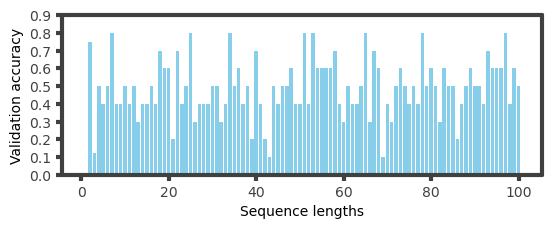

In [9]:
## Check for large sequence length generalization

# Evaluate model generalization for sequences of varying lengths
N = 100
stepsize = 1
val_acc = []
for n in trange(1, N + 1, stepsize):
    val_data = seq_data(device, problem, encoding, n_datapoints=10, seq_len=n)
    dataloader = torch.utils.data.DataLoader(val_data, batch_size=1)
    count = 0
    for x, y in dataloader:
        target = torch.argmax(y).item()
        # out = model.transformer.encoder(x)[0][:, -1, :]
        # prediction = torch.argmax(out).item()
        prediction = model.predict(x)
        if prediction == target:
            count += 1

    accuracy = count / len(dataloader)
    val_acc.append(accuracy)

# Visualize validation error for varying sequence lengths
publication.set_color_mixed()
fig = plt.figure(figsize=(6, 2))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.bar(np.arange(1, N + 1, stepsize), val_acc, color="skyblue")
ax.set_xlabel("Sequence lengths")
ax.set_ylabel("Validation accuracy")
# ax.set_title("Model Generalization Across Sequence Lengths")
ax.set_yticks(np.arange(0, 1, 0.1))
if save:
    publication.pub_show(save_path=f"plots/automaton_dynamics/{settings}_validation")
else:
    publication.pub_show()

In [10]:
dataloader = torch.utils.data.DataLoader(training_datasets[-1], batch_size=1)
count = 0
for x, y in dataloader:
    target = torch.argmax(y).item()
    print(x)
    print(model(x, y))
    prediction = model.predict(x)
    if prediction == target:
        count += 1

accuracy = count / len(dataloader)
accuracy

tensor([[[0., 1.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [0., 1.]]], device='cuda:0')
(tensor([[0.8025, 0.2037]], device='cuda:0', grad_fn=<LeakyReluBackward0>), tensor([[0.8025, 0.2037]], device='cuda:0', grad_fn=<LeakyReluBackward0>))
tensor([[[0., 1.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [0., 1.]]], device='cuda:0')
(tensor([[0.7082, 0.3869]], device='cuda:0', grad_fn=<LeakyReluBackward0>), tensor([[0.7082, 0.3869]], device='cuda:0', grad_fn=<LeakyReluBackward0>))
tensor([[[1., 0.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [1., 0.]]], device='cuda:0')
(tensor([[0.9391, 0.1279]], device='cuda:0', grad_fn=<LeakyReluBackward0>), tensor([[0.9391, 0.1279]], device='cuda:0', grad_fn=<LeakyReluBackward0>))
tensor([[[1., 0.],
         [0., 1

0.48828125

In [11]:
## Training run
compiler.training_run(
    training_datasets,
    n_epochs=n_epochs,
    batch_size=128,
)

Training:   0%|          | 0/2000 [00:00<?, ?steps/s]


TypeError: Transformer.forward() missing 1 required positional argument: 'y'

In [ ]:
## compute percentage merged as function of seq len

In [ ]:
## ON TRANSFORMER TEST BEHAVIOUR ON ARBITRAY LONG RANGE SEQUENCE

In [ ]:
## Visualize automaton dynamics

# Filter and process data for visualization
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()
query = "(Dataset <10) "
data_hid = data_hid.query(query).copy()
data_output = data_output.query(query).copy()

epochs = list(set(data_hid.index.get_level_values("Epoch")))
epochs.sort()

std = float(np.linalg.norm(data_hid.std()))
n_points = len(data_hid.query("Epoch == 0"))

automaton_history = to_automaton_history(
    data_hid, data_output, merge_distance=0.1 * std
)
loss = compiler.trackers["loss"].get_trace()
val_loss = loss.query("Dataset==0")[0].to_numpy()
train_loss = loss.query("Dataset>0").groupby("Epoch").mean()
n_states = np.array([len(automaton.states) for automaton in automaton_history])

In [ ]:
## plot number of reduced states

In [ ]:
n_datapoints = sum(len(dataset) for dataset in analysis_data)

publication.set_color_mixed()
plt.figure(figsize=(8, 3))
plt.plot(train_loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")
# plt.plot(n_states / n_datapoints, label="Number of states", zorder=0, color="0.5")
plt.plot(n_states / n_datapoints, label="Number of states", zorder=0)
plt.xlabel("epochs")
plt.ylim(0)
plt.legend()
if save:
    publication.plt_show(save_path=f"plots/automaton_dynamics/{settings}_loss")
else:
    publication.plt_show()

In [ ]:
n_datapoints = sum(len(dataset) for dataset in training_datasets)

publication.set_color_mixed()
plt.figure(figsize=(3, 2))
plt.plot(train_loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")
plt.xlabel("epochs")
plt.ylim(0)
plt.legend()
if save:
    publication.plt_show(save_path=f"plots/automaton_dynamics/{settings}_loss_small")
else:
    publication.plt_show()

In [ ]:
match settings:
    case "rich":
        epoch_choices = [0, 1000, 1999]
    case "intermediate":
        epoch_choices = [0, 350, 660, 1999]
    case "lazy":
        epoch_choices = [0, 1999]
    case "low_data":
        epoch_choices = [0, 600,1999]

for epoch in epoch_choices:
    automaton = automaton_history[epoch]
    display_automata(automaton)
    if save:
        publication.pub_show(
            save_path=f"plots/automaton_dynamics/{settings}_automaton_epoch_{epoch}"
        )
    else:
        publication.pub_show()

In [ ]:
automaton = to_automaton(
    hidden_function,
    output_function,
    initial_hidden,
    training_datasets,
    encoding,
    merge_distance_frac=0.1,
)
display_automata(reduce_automaton(automaton))
if save:
    publication.pub_show(
        save_path=f"plots/automaton_dynamics/{settings}_automaton_reduced"
    )
else:
    publication.pub_show()

In [ ]:
stop

In [ ]:
# Create animation
publication.set_color_mixed()
animation = SliderAnimation(
    {
        "Hidden representations": ActivationsAnimation(
            data_hid, transform="PCA", colors=[5] * n_points
        ),
        "Output": ActivationsAnimation(
            data_output,
            transform="none",
            fixed_points=encoding.encoding,
            colors=[6] * n_points,
        ),
        "Automaton": AutomatonAnimation(automaton_history, reduce_automata=False),
        "Loss": EpochAnimation(
            graphs={
                "Training loss": train_loss,
                "Validation loss": val_loss,
            },
            unitless_graphs={
                "Number of states": n_states,
            },
            y_bounds=(0, 1),
        ),
    },
    parameters=epochs,
    parameter_name="Epoch",
    fig_size=4,
)

# Optionally export the animation
# if save:
#     animation.to_gif(f"plots/automaton_dynamics_{settings}")

In [ ]:
import scipy
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm

import numpy as np

data_hid = compiler.trackers["hidden"].get_trace()
counts = []
# for n, h in tqdm(data_hid.groupby("Epoch")):
#     H = h.to_numpy()
#     if n == 0:
#         dist = scipy.spatial.distance_matrix(H, H)
#         threshold = 0.01 * np.max(dist)
#     clustering = AgglomerativeClustering(
#         n_clusters=None, distance_threshold=threshold
#     ).fit(H)
#     count = max(clustering.labels_)
#     counts.append(count)


def count_states(H):
    dist = scipy.spatial.distance_matrix(H, H)
    fraction = 1 / dist
    fraction = np.sum(np.nan_to_num(fraction, nan=0.0, posinf=0.0, neginf=0.0))
    return fraction


for n, h in tqdm(data_hid.groupby("Epoch")):
    H = h.to_numpy()
    counts.append(count_states(H))

loss = compiler.trackers["loss"].get_trace()
val_loss = loss.query("Dataset==0")[0].to_numpy()
train_loss = loss.query("Dataset>0").groupby("Epoch").mean()
# counts = scipy.ndimage.gaussian_filter(counts, 5)
plt.plot(train_loss)
plt.plot(val_loss)
plt.plot(np.array(counts) / (H.shape[0]))
# plt.ylim(0, 1)
plt.show()